In [1]:
# import modules

## keras
# VGG16- network contains total 16 layers(A total of 13 convolutional layers, 3 dense layers )
# Keras library also provides the pre-trained model in which one can load the saved model weights, 
# and use them for different purposes : transfer learning, image feature extraction, and object detection
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as keras_image # for loading, convert image to array

## pretrained model
# ResNet-50 is a convolutional neural network that is 50 layers deep
# for feature extraction
from keras.applications.resnet50 import ResNet50

# feature selection and classifier for predictions 
from sklearn.feature_selection import VarianceThreshold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

## others
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# mount drive to load data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# folder path
dir_path = '/content/drive/My Drive/Fruits_Color_Extraction/fruits-data'

In [4]:
# load dataset from google drive
dir_path = os.listdir(dir_path + '/' + 'train')
num_labels = [i for i in range(len(dir_path))]
label_dict = dict(zip(dir_path, num_labels))

In [5]:
dir_path, len(num_labels)

(['Tomato Cherry Red',
  'Apple Crimson Snow',
  'Tomato 4',
  'Tomato 1',
  'Apple Braeburn',
  'Apple Red 1'],
 6)

**Praparing DataFrame**

In [6]:
# helper function for preparing dataframe of images paths and associated labels
def image_paths(folder):
  img_path = []
  label = []
  for train_folder in os.listdir(folder):
    fruit_name_folder = os.path.join(folder, train_folder)
    if 'Apple' in fruit_name_folder:
        img_names = os.listdir(fruit_name_folder)
        for img_name in img_names:
            img_path.append(fruit_name_folder + '/' + img_name)
            label.append('apple')
    else:
        img_names = os.listdir(fruit_name_folder)
        for img_name in img_names:
            img_path.append(fruit_name_folder + '/' + img_name)
            label.append('tomato')
  df = pd.DataFrame(list(zip(img_path, label)), columns=['images_path', 'label'])
  return df

In [7]:
train_dir_path = '/content/drive/My Drive/Fruits_Color_Extraction/fruits-data/train'
data_frame = image_paths(train_dir_path)

In [8]:
data_frame.head()

,images_path,label
0,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
1,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
2,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
3,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
4,/content/drive/My Drive/Fruits_Color_Extractio...,tomato


In [9]:
data_frame.shape

(3137, 2)

In [10]:
data_frame.label.value_counts()

tomato    1709
apple     1428
Name: label, dtype: int64

In [11]:
df = data_frame.sample(frac=1).reset_index(drop=True)
df.head()

,images_path,label
0,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
1,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
2,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
3,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
4,/content/drive/My Drive/Fruits_Color_Extractio...,apple


In [18]:
temp1 = [i for i in range(1000) if data_frame['label'][i]=='tomato']
len(temp1)

556

In [13]:
# check for wrong labels if any
temp = [i for i in range(len(data_frame)) if 'tomato' not in data_frame['label'][i] and 'apple' in data_frame['images_path'][i]] 
temp # no wrong labels

[]

**Show Images**

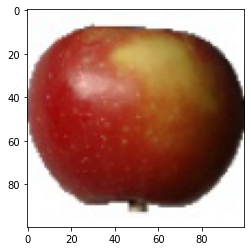

In [19]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
image_1 = image.imread(data_frame['images_path'][2301])
# display the array of pixels as an image
pyplot.imshow(image_1)
pyplot.show()

**Feature Extraction using PreTrained Models**

We can use pre-trained models for feature extraction, The extracted features can be used for Machine Learning purposes.

Here I used ResNet50 pretrained model for feature extraction

First step is to load the weights of the pre-trained model in the model architecture. 

Notice, that an additional argument is passed 
include_top = False, which states that we do not want to add the last layer of this architecture

In [20]:
# load weights of pretrained model
resnet = ResNet50(weights='imagenet', include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [21]:
df.head()

,images_path,label
0,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
1,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
2,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
3,/content/drive/My Drive/Fruits_Color_Extractio...,tomato
4,/content/drive/My Drive/Fruits_Color_Extractio...,apple


In [22]:
## helper function to extract features
def extract_features(path_img):
  img = keras_image.load_img(path_img, target_size=(224, 224))
  img_to_data = keras_image.img_to_array(img)
  img_to_data = np.expand_dims(img_to_data, axis=0)
  img_to_data = preprocess_input(img_to_data)
  features = resnet.predict(img_to_data)
  return features

In [23]:
# sample features 
feature_resnet = extract_features(df['images_path'][0])

In [24]:
# flatten or squeeze(produce 3D matrix) features to use them in ML models 
feature_resnet.flatten().shape, feature_resnet.squeeze().shape
# 7*7*2048 = 100352

((100352,), (7, 7, 2048))

**Transfer learning**

Implementation of transfer learning using pre-trained model features

In [25]:
# extract features using above dataframe
features_df = pd.DataFrame()
count = 0 # for now extracting features 1000 samples for training
for i in tqdm(range(len(df))):
  temp = [] # for flatten features
  temp_features = extract_features(df['images_path'][i])
  temp.append(temp_features.flatten())
  temp_df = pd.DataFrame(temp)
  #print(temp_df.head())
  temp_df['label'] = df['label'][i]
  features_df = features_df.append(temp_df, ignore_index=True)
  count += 1
  if count == 1000:
    break

 32%|███▏      | 999/3137 [1:22:57<3:03:51,  5.16s/it]

In [26]:
features_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100313,100314,100315,100316,100317,100318,100319,100320,100321,100322,100323,100324,100325,100326,100327,100328,100329,100330,100331,100332,100333,100334,100335,100336,100337,100338,100339,100340,100341,100342,100343,100344,100345,100346,100347,100348,100349,100350,100351,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,5.882560,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.047639,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tomato
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,6.172366,0.0,0.0,0.000000,0.0,1.027196,...,0.195172,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.358569,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tomato
2,0.0,0.0,0.0,0.0,0.0,0.0,1.009686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068407,0.0,0.0,10.766008,0.0,0.0,0.008166,0.0,0.339929,...,1.028843,0.0,0.0,0.0,0.0,1.059618,0.0,0.0,0.0,1.058195,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.273196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tomato
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.929042,0.0,0.0,0.000000,0.0,2.131496,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tomato
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.803910,0.0,0.0,0.000000,0.0,2.664079,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.573662,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,apple


In [27]:
features_df.shape

(1000, 100353)

In [28]:
temp_total = [i for i in range(len(features_df)) if features_df['label'][i] == 'tomato']
len(temp_total), temp_total[0:5] # tomato-1215, apple-987

(552, [0, 1, 2, 3, 5])

In [29]:
# prepare features_df to input(X) and ouput (y) variables
X = features_df.drop('label', axis=1)
y = features_df.label

In [30]:
# load model for classification
model = MLPClassifier(hidden_layer_sizes=(100, 10))
pipeline = Pipeline([('low_variance_filter', VarianceThreshold()), ('model', model)])
pipeline.fit(X, y)
print ("Model Trained")

Model Trained


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [52]:
# test predictions
# sample features 
temp_test = [] # for flatten features
feature_resnet = extract_features(df['images_path'][2301])
temp_test.append(temp_features.flatten())
temp_test_df = pd.DataFrame(temp_test)
temp_test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,100312,100313,100314,100315,100316,100317,100318,100319,100320,100321,100322,100323,100324,100325,100326,100327,100328,100329,100330,100331,100332,100333,100334,100335,100336,100337,100338,100339,100340,100341,100342,100343,100344,100345,100346,100347,100348,100349,100350,100351
0,0.0,0.0,0.0,0.0,0.0,0.0,0.409863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.550306,0.0,0.0,0.0,0.0,1.116582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
preds = pipeline.predict(temp_test_df)

In [54]:
preds

array(['apple'], dtype='<U6')

In [34]:
import pickle
## dump model
pickle_out = open("/content/drive/My Drive/Fruits_Color_Extraction/fruit_model.pickle","wb")
pickle.dump(pipeline, pickle_out)
pickle_out.close()

In [35]:
## load model
pickle_in = open("/content/drive/My Drive/Fruits_Color_Extraction/fruit_model.pickle","rb")
model = pickle.load(pickle_in)

In [36]:
model.predict(temp_test_df)

array(['tomato'], dtype='<U6')

**TestSet Data**

In [37]:
# test data for predictions
test_dir_path = '/content/drive/My Drive/Fruits_Color_Extraction/fruits-data/test'
data_frame_test = image_paths(train_dir_path)

In [47]:
# extract features using above dataframe
test_features_df = pd.DataFrame()
for i in range(3120,3136):
  temp = [] # for flatten features
  temp_features = extract_features(data_frame_test['images_path'][i])
  temp.append(temp_features.flatten())
  temp_df = pd.DataFrame(temp)
  temp_df['label'] = data_frame_test['label'][i]
  test_features_df = test_features_df.append(temp_df, ignore_index=True)

In [48]:
test_features_df.shape

(16, 100353)

In [49]:
test_X = test_features_df.drop('label', axis=1)

In [50]:
preds = model.predict(test_X)

In [51]:
preds

array(['apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple',
       'apple', 'apple', 'apple', 'apple', 'apple', 'apple', 'apple',
       'apple', 'apple'], dtype='<U6')

In [46]:
data_frame_test.tail(20)

,images_path,label
3117,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3118,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3119,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3120,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3121,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3122,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3123,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3124,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3125,/content/drive/My Drive/Fruits_Color_Extractio...,apple
3126,/content/drive/My Drive/Fruits_Color_Extractio...,apple
